In [1]:
%matplotlib inline

import pandas as pd
import datetime
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import statistics
from scipy import signal
import random
import uuid
import json
import itertools
from pandarallel import pandarallel

In [2]:
#Model parameters
num_machines = 10
num_prod_lines = 5
cyclical_maintenance = 30 #number of days

fault_prob = [0.001, 0.003, 0.005]

#To be decided if the numbers are per day or per hour
scenarios = {
    "normal":
    {
        "avg_yield": 1500,
        "std_yield": 5,
        "avg_perc_defects": 0.01,
        "std_perc_defects": 0.001,
        "avg_energy_cons": 10000,
        "std_energy_cons": 200
    },
    "abnormal": 
    {
        "avg_yield": 1500,
        "std_yield": 10,
        "avg_perc_defects": 0.03,
        "std_perc_defects": 0.003,
        "avg_energy_cons": 20000,
        "std_energy_cons": 500,
    },
    "highly_abnormal": 
    {
        "avg_yield": 1500,
        "std_yield": 20,
        "avg_perc_defects": 0.05,
        "std_perc_defects": 0.005,
        "avg_energy_cons": 30000,
        "std_energy_cons": 500,
    }
}

In [3]:
def gaussian_distr(mean, std, size):
    return np.random.normal(loc=mean, scale=std, size=size)

def possoin_distr(prob, size):
    return np.random.poisson(lam=prob, size=size)

a = gaussian_distr(scenarios["normal"]["avg_yield"], scenarios["normal"]["std_yield"], 10000)
b = gaussian_distr(scenarios["normal"]["avg_perc_defects"], scenarios["normal"]["std_perc_defects"], 10000)
#print(a)

In [4]:
def plot_hist(data, step, title):
    fig, ax = plt.subplots()
    #plt.xlabel("a")
    #plt.ylabel(r"b")
    ax.grid()
    plt.hist(data, bins=np.arange(data.min(), data.max(), step))
    plt.title(title)
    plt.show();

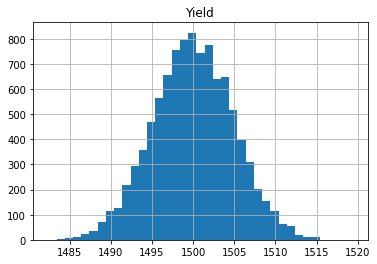

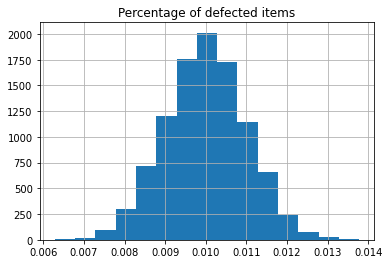

In [5]:
plot_hist(a, 1, "Yield")
plot_hist(b, 0.0005, "Percentage of defected items")

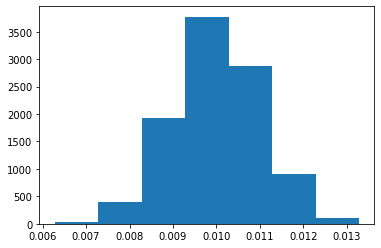

In [6]:
#plt.hist(a, bins=np.arange(a.min(), a.max()+1, 1))
plt.hist(b, bins=np.arange(b.min(), b.max(), 0.001))
plt.show()

In [7]:
def next_maint(data, df, list_maint):
    output = None
    #print(data)
    #print(list_maint)
    for x, y in zip(list_maint, list_maint[1:]):
        #print(x, y)
        if(data >= x and data <= y):
            output=df.iloc[y]['Timestamp']
            #print(y, output)
    return output

In [8]:
def generateTimeSeries(months):
    
    date_rng = pd.date_range(start=datetime.date.today() - datetime.timedelta(months*365/12), 
                             end=datetime.date.today(), freq='H')
    df = pd.DataFrame(date_rng, columns=['Timestamp'])
    
    df['year'] = df.Timestamp.dt.year
    df['month'] = df.Timestamp.dt.month
    df['day'] = df.Timestamp.dt.day
    df['index'] = df.Timestamp.index
    
    df['CycMaintenance'] = 0
    df.loc[(df.Timestamp.dt.day%28 == 0) & (df.Timestamp.dt.hour%13 == 0) & 
           (df.Timestamp.dt.hour != 0), 'CycMaintenance'] = 1
    #print(df[df['CycMaintenance'] == 1])
    
    list_maint = df[df.CycMaintenance == 1].index.tolist()
    list_maint.append(df.index.min())
    list_maint.append(df.index.max())
    list_maint.sort()
    print(list_maint)
    
    df['NextMaintenance'] = df['index'].apply(next_maint, args=(df, list_maint))

    df1 = pd.DataFrame(range(1, num_machines+1), columns=['MachineID'])
    df2 = pd.DataFrame(range(1, num_prod_lines+1), columns=['ProdLineID'])

    df_tot = df2.merge(df1, how='cross')
    df_tot['FaultProb'] = random.choices(fault_prob, k = len(df_tot))
    df_tot = df.merge(df_tot, how='cross')
    
    df_tot['EnergyCons'] = gaussian_distr(scenarios["normal"]["avg_energy_cons"], 
                                          scenarios["normal"]["std_energy_cons"], len(df_tot))
    
    df_tot['Yield'] = gaussian_distr(scenarios["normal"]["avg_yield"], 
                                          scenarios["normal"]["std_yield"], len(df_tot))
    
    df_tot['DefectedItems'] = df_tot['Yield']*gaussian_distr(scenarios["normal"]["avg_perc_defects"], 
                                          scenarios["normal"]["std_perc_defects"], len(df_tot))
    
    
    return df_tot

In [30]:
df = generateTimeSeries(3)

[0, 661, 1405, 2149, 2184]


In [31]:
#print(df['ProdLineID'].unique())
df['Fault'] = 0

for i in df['ProdLineID'].unique():
    #print(i)
    for j in df['MachineID'].unique():
        #print(str(i)+", "+str(j))
        #print(df[(df.ProdLineID == i) & (df.MachineID == j)]['FaultProb'].unique())
        temp = (df[(df.ProdLineID == i) & (df.MachineID == j)]).copy()
        temp = temp[['FaultProb','Fault']]
        #print(len(temp))
        temp['Fault'] = possoin_distr(temp['FaultProb'].unique(), len(temp))
        df.loc[temp.index , 'Fault'] = temp['Fault']

#print(df)

In [32]:
#print(list(scenarios.keys())[1:])
#print(random.choices(list(scenarios.keys())[1:], k = len(df[df.Fault == 1])))
df['FaultType'] = 'normal'
df.loc[df.Fault == 1, 'FaultType'] = random.choices(list(scenarios.keys())[1:2], k = len(df[df.Fault == 1]))

In [33]:
print(df[(df.ProdLineID == 1) & (df.MachineID == 1) & (df.Fault == 1)])
df_fault = df[df.Fault == 1]

                 Timestamp  year  month  day  index  CycMaintenance  \
26650  2021-12-23 05:00:00  2021     12   23    533               0   
100800 2022-02-23 00:00:00  2022      2   23   2016               0   

           NextMaintenance  ProdLineID  MachineID  FaultProb   EnergyCons  \
26650  2021-12-28 13:00:00           1          1      0.001  9644.698422   
100800 2022-02-28 13:00:00           1          1      0.001  9789.108924   

              Yield  DefectedItems  Fault FaultType  
26650   1503.239008      15.058345      1  abnormal  
100800  1499.468461      14.550919      1  abnormal  


In [34]:
def assign_faults_tbm(data, temp, stop_tbm):
    output = data['Fault']
    data = data['Timestamp']
    temp1 = temp[(temp.Fault == 1) & (temp.Timestamp < stop_tbm)]
    #print(data)
    for index, row in temp1.iterrows():
        #print(data,row['Timestamp'],row['NextMaintenance'])
        if((data >= row['Timestamp']) & (data < row['NextMaintenance']) & (data < stop_tbm)):
            output = 1
    # print(output)
    return output

In [35]:
def generate_faults_pdm(temp, start_pdm, fault_hours):
    output = 0
    temp1 = temp[(temp.Fault == 1) & (temp.Timestamp >= start_pdm)]
    fault_ts = temp1.Timestamp.values
    #print(fault_ts)
    for i in fault_ts:
        #print(i)
        temp.loc[(temp.Timestamp >= i) & (temp.Timestamp <= (i+np.timedelta64(fault_hours, 'h'))), 'Fault'] = 1

In [36]:
def generate_faults(df):
    start_pdm = df.loc[int(len(df['Timestamp'])/2)]['Timestamp']
    print(start_pdm)
    #pandarallel.initialize()
    temp_list = []
    for i,j in itertools.product(df['ProdLineID'].unique(), df['MachineID'].unique()):
    #for i,j in itertools.product([1],[1]):
        print(str(i)+", "+str(j))
        temp = (df[(df.ProdLineID == i) & (df.MachineID == j)]).copy()
        temp['Fault'] = temp[['Timestamp','Fault']].apply(assign_faults_tbm, args=(temp, start_pdm), axis=1)
        generate_faults_pdm(temp, start_pdm, 12)
        temp_list.append(temp)
    return pd.concat(temp_list)   

In [37]:
df = generate_faults(df)

2022-01-15 12:00:00
1, 1
1, 2
1, 3
1, 4
1, 5
1, 6
1, 7
1, 8
1, 9
1, 10
2, 1
2, 2
2, 3
2, 4
2, 5
2, 6
2, 7
2, 8
2, 9
2, 10
3, 1
3, 2
3, 3
3, 4
3, 5
3, 6
3, 7
3, 8
3, 9
3, 10
4, 1
4, 2
4, 3
4, 4
4, 5
4, 6
4, 7
4, 8
4, 9
4, 10
5, 1
5, 2
5, 3
5, 4
5, 5
5, 6
5, 7
5, 8
5, 9
5, 10


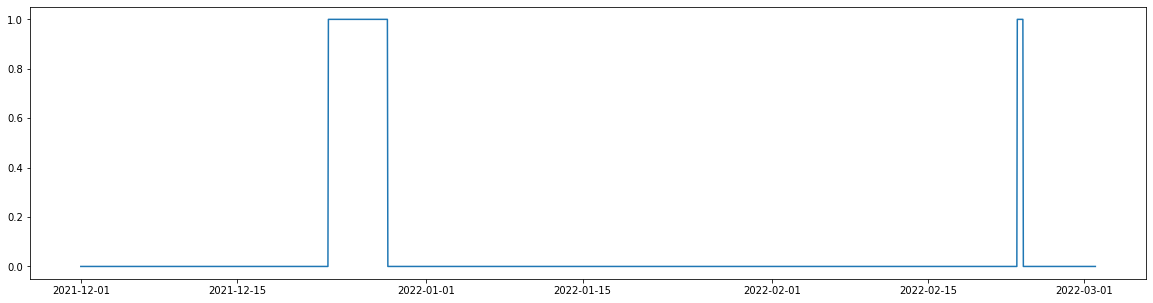

In [40]:
plt.figure(figsize=(20,5))
plt.plot(df[(df.ProdLineID == 1) & (df.MachineID == 1)]['Timestamp'],
         df[(df.ProdLineID == 1) & (df.MachineID == 1)]['Fault'])